In [1]:
# NUMPY & PANDAS
import numpy as np
import pandas as pd

# MATPLOTLIB
import matplotlib.pyplot as plt

# SCI_KIT LEARN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.kernel_ridge import KernelRidge
from sklearn import datasets

# SHOGUN
from shogun import *

from time import time

###### READ THE CSV FILE 

In [2]:
df = pd.read_csv('../data/nyc-sales.csv')

for i in range(len(df)):
    if(df.loc[i,'SALE PRICE'] == ' -  '):
        df.at[i,'SALE PRICE'] = np.nan
        
# test is the data with 'SALE PRICE' == NaN
df_test = df[df['SALE PRICE'].isna()]

#train is the cleaned data
df_train = df[df['SALE PRICE'].notna()]


# training set
col_x = [col for col in df.columns
      if col != 'SALE PRICE']
X_train = df_train[col_x]

# target variable
target = ['SALE PRICE']

y_train = df_train[target]

In [3]:
encoder = LabelEncoder()

s = (X_train.dtypes == 'object')

cat_vars = list(s[s].index)

# drop the unwanted columns
X_new = X_train.drop(columns=['Unnamed: 0','NEIGHBORHOOD','ADDRESS','EASE-MENT',
                              'BUILDING CLASS CATEGORY','SALE DATE','APARTMENT NUMBER'])

s = (X_new.dtypes == 'object')
cat_varsx = list(s[s].index)

#  Labeling properly the columns with object data type
le = LabelEncoder()

label_X = X_new.copy()
for col in cat_varsx:
    label_X[col] = le.fit_transform(X_new[col])
    

# label_X contains the cleaned up training set
# Convert features and labels suitable for shogun

label_X= label_X.to_numpy().astype(float)

y_train= y_train.to_numpy().astype(float)
y_train = y_train.reshape(y_train.shape[0],) #reshape to (num_samples)

In [4]:
time_skl = []
time_sgn = []
time_diff = []
size = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]

In [5]:

for i in size:
    #Dropping some data to account for Memory error, see issue #2
    print(i)
    
    label_X_temp = label_X[:i]
    y_train_temp = y_train[:i]
    skr = KernelRidge(kernel='rbf', gamma=0.1)

    t0 = time()
    skr.fit(label_X_temp, y_train_temp)
    tsk1 = time() - t0
    time_skl.append(tsk1)

    train_features = RealFeatures(label_X_temp.T)
    labels_train = RegressionLabels(y_train_temp)

    width = 0.1
    kernel = GaussianKernel(train_features, train_features, width)
    tau = 1
    krr = KernelRidgeRegression(tau, kernel, labels_train)

    t0=time()
    krr.train()
    tsg1=time()-t0

    time_sgn.append(tsg1)
   
    #Final remarks
    print("\n")
    print("Sklearn: " + str(tsk1))
    print("Shogun : " + str(tsg1))


1000


Sklearn: 0.34187960624694824
Shogun : 0.18551850318908691
2000


Sklearn: 0.4000663757324219
Shogun : 0.6937048435211182
3000


Sklearn: 0.8451399803161621
Shogun : 1.9593496322631836
4000


Sklearn: 1.9818878173828125
Shogun : 4.251707315444946
5000


Sklearn: 2.908586263656616
Shogun : 7.370640754699707
6000


Sklearn: 4.401869058609009
Shogun : 10.986946105957031
7000


Sklearn: 5.35564112663269
Shogun : 17.396749019622803
8000


Sklearn: 9.189361333847046
Shogun : 25.295066118240356
9000


Sklearn: 10.054980993270874
Shogun : 35.833691358566284
10000


Sklearn: 14.067751407623291
Shogun : 46.599146127700806


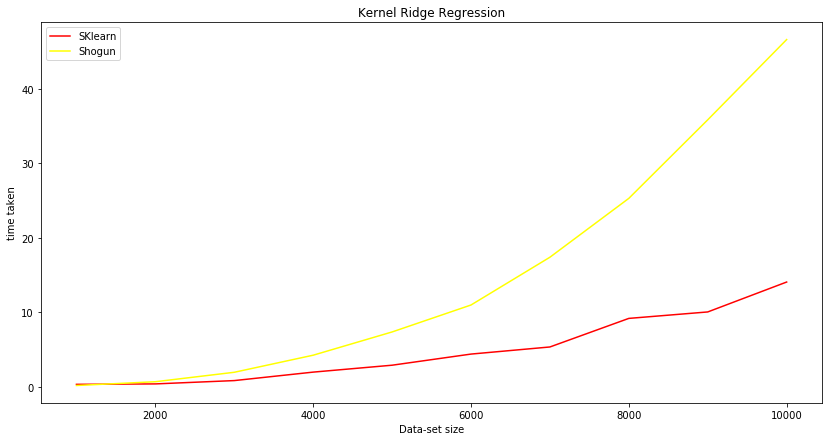

In [6]:
# PLOTTING
plt.figure(figsize=(14,7))
plt.title('Kernel Ridge Regression')
plt.plot(size,time_skl,color='red',label='SKlearn')
plt.plot(size,time_sgn,color='yellow',label='Shogun')
plt.xlabel('Data-set size')
plt.ylabel('time taken')
plt.legend()